In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
from collections import defaultdict

from Components.ConditionalNormalDistribution import ConditionalNormalDistribution
from Components.DifferentiablePolynomial import DifferentiablePolynomial
from Models.ModelExponential import ModelExponential
from Models.ModelSinCos import ModelSinCos
from Models.ModelLogistic import ModelLogistic
from Models.ModelLinearRegression import ModelLinearRegression
from Models.ModelSigmoid import ModelSigmoid
from Composition.SequentialSystem import SequentialSystem
from SearchAlgorithm.skeleton import BO_skeleton, BO_graph, BO_graph_local_loss, BO_graph_turbo

from GraphDecomposition.DirectedFunctionalGraph import DirectedFunctionalGraph
from Components.DifferentiablePolynomial import DifferentiablePolynomial
from Models.ModelSinCos import ModelSinCos
from Models.ModelConstant import ModelConstant
from Models.ModelWeightedSum import ModelWeightedSum
from Models.ModelWeightedSumThree import ModelWeightedSumThree
from Models.ModelExponential import ModelExponential

%load_ext autoreload
%autoreload 2
from GraphDecomposition.Heuristic import *
from helper import *
from Plotting.HeatMapLossFunction import *



In [2]:
from Models.ModelMNIST import ModelMNIST
from mnist.MNISTLoader import *
from helper import *

ground_truth_param_mnist = {"Blackbox_DoctorA": np.array([0.7,0.3]), "Blackbox_DoctorB": np.array([0.4,0.4,0.2]), 
                            "model_aggregate": np.array([0.7,0.3])}


In [3]:
def create_healthcare_system(param, noise=0.5, seed=11):  
    np.random.seed(seed)
    dg_nn = DirectedFunctionalGraph(noise)
    
    # white box components
    dg_nn.add_node("model_heart_disease", component=ModelLogistic(21))
    x,y = get_heart_disease_data()
    dg_nn.nodes["model_heart_disease"]["component"].attach_local_data(x,y)
 
    dg_nn.add_node("model_liver_hep", component=ModelLogistic(14))
    x,y = get_hepatitis_data()
    
    dg_nn.nodes["model_liver_hep"]["component"].attach_local_data(x,y)
    
    dg_nn.add_node("model_kidney", component=ModelLogistic(146))
    x,y = get_kidney_data()
    dg_nn.nodes["model_kidney"]["component"].attach_local_data(x,y)
    
    dg_nn.add_node("model_body_fat", component=ModelLinearRegression(15))
    x,y = get_body_fat_data()
    dg_nn.nodes["model_body_fat"]["component"].attach_local_data(x,y)

    dg_nn.add_node("Blackbox_DoctorA", component=ModelWeightedSum())
    dg_nn.add_node("Blackbox_DoctorB", component=ModelWeightedSumThree())
    
    dg_nn.add_node("model_aggregate", component=ModelWeightedSum())
    x,y = get_data_tree(dg_nn.nodes["model_aggregate"]["component"], 0, 2, param["model_aggregate"])
    dg_nn.nodes["model_aggregate"]["component"].attach_local_data(x,y)
    
    dg_nn.add_edge(("model_liver_hep", "model_kidney", "model_body_fat"), "Blackbox_DoctorB")
    dg_nn.add_edge(("model_heart_disease", "model_body_fat"), "Blackbox_DoctorA")
    dg_nn.add_edge(("Blackbox_DoctorA", "Blackbox_DoctorB"), "model_aggregate")

    x,y = get_end_to_end_nn_data(dg_nn, ground_truth_param_mnist, seed=seed)

    dg_nn.system_x = x
    dg_nn.system_y = y
    return dg_nn

In [4]:
data_generation_seed = 3
noise_perturb = -1
noise_std = 0.5
dg_healthcare = create_healthcare_system(ground_truth_param_mnist, noise_perturb, data_generation_seed)
dg_healthcare.to_perturb = True
dg_healthcare.noise_std = noise_std

adding edge from model_liver_hep to Blackbox_DoctorB
adding edge from model_kidney to Blackbox_DoctorB
adding edge from model_body_fat to Blackbox_DoctorB
adding edge from model_heart_disease to Blackbox_DoctorA
adding edge from model_body_fat to Blackbox_DoctorA
adding edge from Blackbox_DoctorA to model_aggregate
adding edge from Blackbox_DoctorB to model_aggregate
setting:  [0.7 0.3]
setting:  [0.4 0.4 0.2]
setting:  [0.7 0.3]


In [6]:
len(dg_healthcare.get_all_params()[1])

198

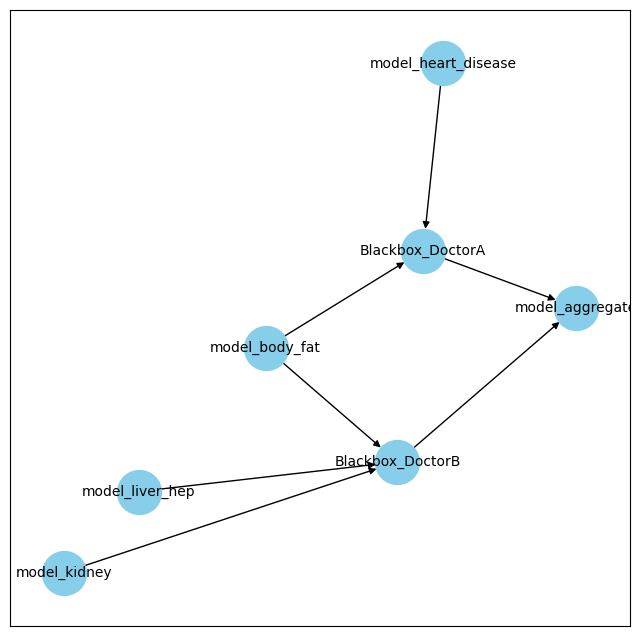

In [6]:
plt.figure(figsize=(8,8))
nx.draw_networkx(dg_healthcare, font_size=10, node_size=1000, node_color="skyblue")

plt.show()

In [8]:
dg_healthcare.nodes

NodeView(('model_heart_disease', 'model_liver_hep', 'model_kidney', 'model_body_fat', 'Blackbox_DoctorA', 'Blackbox_DoctorB', 'model_aggregate'))

final system loss:  tensor(4.9140, dtype=torch.float64)


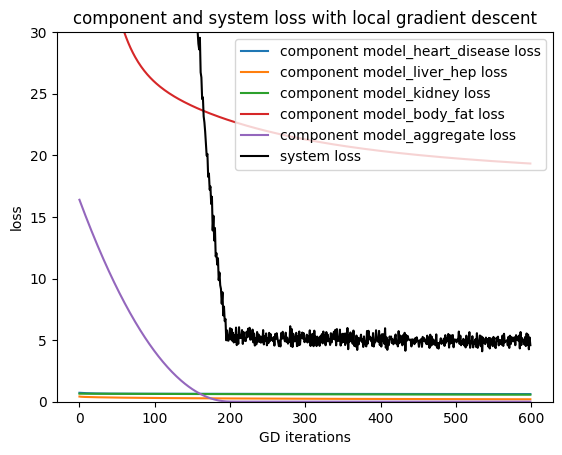

best system loss: tensor(4.0924, dtype=torch.float64)


In [9]:
torch.manual_seed(10)
#grad descent
dg_healthcare.random_initialize_param(11)
lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_healthcare, itr=600, y_min=0, y_max=30, plot=True)
lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]
print("best system loss:", min(all_loss["system"]))

# torch.manual_seed(10)
# #grad descent
# dg_healthcare.random_initialize_param(11)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_healthcare, itr=300, y_min=0, y_max=30, plot=True)
# lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]
# print("best system loss:", min(all_loss["system"]))

# torch.manual_seed(10)
# #grad descent
# dg_healthcare.random_initialize_param(11)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_healthcare, itr=300, y_min=0, y_max=30, plot=True)
# lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]
# print("best system loss:", min(all_loss["system"]))

# torch.manual_seed(10)
# #grad descent
# dg_healthcare.random_initialize_param(11)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_healthcare, itr=300, y_min=0, y_max=30, plot=True)
# lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]
# print("best system loss:", min(all_loss["system"]))

# torch.manual_seed(10)
# #grad descent
# dg_healthcare.random_initialize_param(11)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_healthcare, itr=300, y_min=0, y_max=30, plot=True)
# lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]
# print("best system loss:", min(all_loss["system"]))

In [10]:
lower_bound_local_loss

[0.6211327418126109,
 0.19782915278196134,
 0.5695528909465346,
 19.334897053728767,
 0.006265516611326873]

In [140]:
import numpy as np
from scipy import stats

system_a = [0.1338, 0.1602, 0.1485, 0.1442]
system_b = [0.2171, 0.1704, 0.2231, 0.2056, 0.1934]
healthcare = [5.01314, 5.6127, 5.1137, 4.9069, 4.4711]
print("mean")
print(np.array(system_a).mean())
print(np.array(system_b).mean())z
print(np.array(healthcare).mean())
print(stats.sem(system_a))
print(stats.sem(system_b))
print(stats.sem(healthcare))

mean
0.146675
0.20191999999999996
5.023508
0.0054631149539434015
0.009377281055828496
0.18359484323912809


In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
x,y = get_body_fat_data()
reg = LinearRegression().fit(x, y)
print(mean_squared_error(y, reg.predict(x)))

12.688716


In [88]:

dg_healthcare.random_initialize_param(72)
print(dg_healthcare.nodes["model_heart_disease"]["component"].model.weight)
print(dg_healthcare.nodes["model_heart_disease"]["component"].get_local_loss())
print(dg_healthcare.nodes["model_heart_disease"]["component"].accuracy())
for x in range(1):
    (dg_healthcare.nodes["model_heart_disease"]["component"].do_one_descent_on_local())
print(dg_healthcare.nodes["model_heart_disease"]["component"].model.weight)
print(dg_healthcare.nodes["model_heart_disease"]["component"].get_local_loss())
print(dg_healthcare.nodes["model_heart_disease"]["component"].accuracy())

Parameter containing:
tensor([[-0.7865,  0.3687,  0.0699, -0.2616, -0.1748,  0.1757,  0.4321, -0.6533,
         -0.8665,  0.0014, -0.1357,  0.8934, -0.1675, -0.5051, -0.1917,  0.2685,
          0.1675,  0.5642,  0.2337,  0.2555, -0.2603]], requires_grad=True)
tensor(0.7058, grad_fn=<AddBackward0>)
55.33769063180828
Parameter containing:
tensor([[-0.7452,  0.3695,  0.0656, -0.3022, -0.1746,  0.1596,  0.4326, -0.6535,
         -0.8664,  0.0016, -0.1359,  0.8933, -0.1675, -0.5050, -0.1918,  0.2685,
          0.1672,  0.5644,  0.2338,  0.2558, -0.2606]], requires_grad=True)
tensor(0.7022, grad_fn=<AddBackward0>)
55.33769063180828


In [ ]:
# dg_healthcare.nodes["model_heart_disease"]["component"].get_params()
dg_healthcare.random_initialize_param(23)
print(dg_healthcare.nodes["model_heart_disease"]["component"].get_local_loss())
for x in range(100):
    (dg_healthcare.nodes["model_heart_disease"]["component"].do_one_descent_on_local())
    print(dg_healthcare.nodes["model_heart_disease"]["component"].get_local_loss())



In [11]:

# vanilla BO
import botorch
import time
botorch.settings.debug = False
botorch.settings.debug

vanilla_all_trials = []
trials = 100
        
for x in range(trials):
    if len(vanilla_all_trials) > 1:
        break

    now = time.time()
    dg_healthcare.random_initialize_param(11)
    #DG.fit_locally_partial(100)
    all_best_losses, _, _ = BO_graph(dg_healthcare,printout=True,iteration=200)
    vanilla_all_trials.append(all_best_losses)
    later = time.time()
    difference = (later - now)
    print("total time taken: ", difference)

vanilla_all_trials = np.array(vanilla_all_trials)
#np.savetxt("result/health_care_vanilla_BO.csv", vanilla_all_trials)


BO iteration:  0
Current best objective:  -10000
current loss:  tensor(-8.1608, dtype=torch.float64)
time taken for one BO iteration:  1.1803038120269775
BO iteration:  1
Current best objective:  tensor(-8.1608, dtype=torch.float64)
current loss:  tensor(-66.4019, dtype=torch.float64)
time taken for one BO iteration:  8.335443019866943
BO iteration:  2
Current best objective:  tensor(-8.1608, dtype=torch.float64)
current loss:  tensor(-49.7861, dtype=torch.float64)
time taken for one BO iteration:  6.233779668807983
BO iteration:  3
Current best objective:  tensor(-8.1608, dtype=torch.float64)
current loss:  tensor(-38.9352, dtype=torch.float64)
time taken for one BO iteration:  6.965529918670654
BO iteration:  4
Current best objective:  tensor(-8.1608, dtype=torch.float64)
current loss:  tensor(-22.6900, dtype=torch.float64)
time taken for one BO iteration:  6.4465882778167725
BO iteration:  5
Current best objective:  tensor(-8.1608, dtype=torch.float64)
current loss:  tensor(-39.7672

In [ ]:
our_bo_trial = 5
loss_space_bo_all_trials = []
for x in range(233):
    print("number of attempts: ", x)
    print("trial of our BO (successful): ", len(loss_space_bo_all_trials))
    if len(loss_space_bo_all_trials) >= our_bo_trial:
        break
    
    #try:
    dg_healthcare.random_initialize_param(11)      
    bounds = torch.tensor([np.array(lower_bound_local_loss) * 1.0, np.array(lower_bound_local_loss) * 3])
    all_best_losses_ours, best_param = BO_graph_local_loss(dg_healthcare, bounds, "nn_lookup", samples=5, iteration=20)
    loss_space_bo_all_trials.append(all_best_losses_ours)
    # except:
    #     continue
    
loss_space_bo_all_trials = np.array(loss_space_bo_all_trials)
np.savetxt("result/health_care_3_neg_1_0.5_start_seed_11_5.csv", loss_space_bo_all_trials)

our_bo_trial = 5
loss_space_bo_all_trials = []
for x in range(233):
    print("number of attempts: ", x)
    print("trial of our BO (successful): ", len(loss_space_bo_all_trials))
    if len(loss_space_bo_all_trials) >= our_bo_trial:
        break
    
    #try:
    dg_healthcare.random_initialize_param(11)      
    bounds = torch.tensor([np.array(lower_bound_local_loss) * 1.0, np.array(lower_bound_local_loss) * 3])
    all_best_losses_ours, best_param = BO_graph_local_loss(dg_healthcare, bounds, "nn_lookup", samples=10, iteration=20)
    loss_space_bo_all_trials.append(all_best_losses_ours)
    # except:
    #     continue
    
loss_space_bo_all_trials = np.array(loss_space_bo_all_trials)
np.savetxt("result/health_care_3_neg_1_0.5_start_seed_11_10.csv", loss_space_bo_all_trials)

our_bo_trial = 5
loss_space_bo_all_trials = []
for x in range(233):
    print("number of attempts: ", x)
    print("trial of our BO (successful): ", len(loss_space_bo_all_trials))
    if len(loss_space_bo_all_trials) >= our_bo_trial:
        break
    
    #try:
    dg_healthcare.random_initialize_param(11)      
    bounds = torch.tensor([np.array(lower_bound_local_loss) * 1.0, np.array(lower_bound_local_loss) * 3])
    all_best_losses_ours, best_param = BO_graph_local_loss(dg_healthcare, bounds, "nn_lookup", samples=20, iteration=20)
    loss_space_bo_all_trials.append(all_best_losses_ours)
    # except:
    #     continue
    
loss_space_bo_all_trials = np.array(loss_space_bo_all_trials)
np.savetxt("result/health_care_3_neg_1_0.5_start_seed_11_20.csv", loss_space_bo_all_trials)

In [92]:
lower_bound_local_loss

[0.6263911128044128,
 0.2574457824230194,
 0.5984729528427124,
 21.398597717285156,
 0.0001971742629099343]

In [9]:

# vanilla BO turbo
import botorch
import time
botorch.settings.debug = False
botorch.settings.debug

vanilla_all_trials = []
trials = 100
        
for x in range(trials):
    if len(vanilla_all_trials) > 1:
        break

    now = time.time()
    dg_healthcare.random_initialize_param(100)
    
    try:
        all_best_losses, _, _ = BO_graph_turbo(dg_healthcare,printout=True,iteration=100,to_normalize_y=False,lower_bound=-2.0, upper_bound=2.0, batch_size=1)
    except:
        print("ERROR")
        continue
    print(len(all_best_losses))
    vanilla_all_trials.append(all_best_losses)
    later = time.time()
    difference = (later - now)
    print("total time taken: ", difference)
# vanilla_all_trials = np.array(vanilla_all_trials)
# np.savetxt("result/turbo_BO_system_A.csv", vanilla_all_trials)

max_len = max([len(x) for x in vanilla_all_trials])
for x in range(0, len(vanilla_all_trials)):
    while len(vanilla_all_trials[x]) < max_len:
        vanilla_all_trials[x].append(vanilla_all_trials[x][-1])

vanilla_all_trials = np.array(vanilla_all_trials)
np.savetxt("result/turbo_BO_system_C_ts.csv", vanilla_all_trials)


tensor([0.2677, 0.3618, 0.7123, 0.0310, 0.5429, 0.3926, 0.8598, 0.8567, 0.9390,
        0.6023, 0.6899, 0.1173, 0.8344, 0.0827, 0.7407, 0.6302, 0.7171, 0.5266,
        0.4053, 0.0307, 0.8213, 0.0118, 0.0054, 0.9607, 0.5815, 0.1177, 0.4939,
        0.2619, 0.6397, 0.9895, 0.6932, 0.4126, 0.3130, 0.9818, 0.7207, 0.5350,
        0.6260, 0.2308, 0.9248, 0.2234, 0.9211, 0.9408, 0.5096, 0.9172, 0.2922,
        0.5778, 0.6194, 0.2053, 0.3703, 0.5456, 0.2116, 0.8923, 0.0013, 0.2025,
        0.9183, 0.3255, 0.7837, 0.5901, 0.3254, 0.4888, 0.8794, 0.1323, 0.6752,
        0.5275, 0.6865, 0.1164, 0.8389, 0.5008, 0.2496, 0.5004, 0.1528, 0.5619,
        0.7670, 0.6909, 0.6614, 0.5812, 0.3681, 0.1230, 0.0721, 0.7912, 0.8940,
        0.5347, 0.5987, 0.3354, 0.2429, 0.7513, 0.4091, 0.7259, 0.5667, 0.3851,
        0.9339, 0.1507, 0.7085, 0.3987, 0.9743, 0.0327, 0.7866, 0.5466, 0.1582,
        0.0296, 0.1630, 0.7866, 0.1217, 0.8445, 0.5881, 0.9087, 0.3270, 0.9635,
        0.3642, 0.0345, 0.9199, 0.7002, 